In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
tf = torchvision.transforms.ToTensor()
from omegaconf import OmegaConf
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL

from taming.models.vqgan import EMAVQ

def imshow(img, cmap='gray', axis=True):
  axis = 'on' if axis else 'off'
  plt.imshow(img, cmap=cmap)
  plt.axis(axis)
  plt.show()

### Load Model

In [3]:
config_path = "logs/2024-08-30T08-57-30_240_f16_c16384_d256_EMAVQGAN/configs/2024-08-30T08-57-30-project.yaml"
config = OmegaConf.load(config_path)

In [4]:
# print(yaml.dump(OmegaConf.to_container(config)))

In [5]:
model = EMAVQ(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/jongmin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jongmin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
ckpt_path = "logs/2024-08-30T08-57-30_240_f16_c16384_d256_EMAVQGAN/checkpoints/epoch=0997-step=0348649-val_rec_loss=0.133.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.cuda().eval()
torch.set_grad_enabled(False)

### Load Image

In [7]:
img_path_list = list(Path("LSDSQ_240_gray").rglob("*.png"))
img_path_list[0]

PosixPath('LSDSQ_240_gray/F9qv9DICZOs:0028:15104.png')

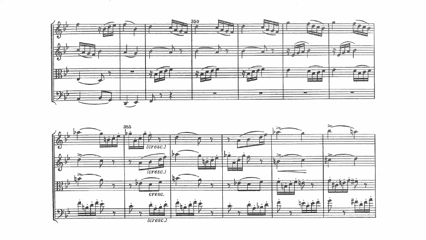

In [8]:
PIL.Image.open(img_path_list[0])

In [9]:
img = tf(PIL.Image.open(img_path_list[0]))
img.shape

torch.Size([1, 240, 426])

### Encode Image

In [10]:
quant, emb_loss, info = model.encode(img.unsqueeze(0).cuda())

In [11]:
quant.shape, emb_loss, info[2].shape

(torch.Size([1, 256, 15, 26]),
 tensor(0.0002, device='cuda:0'),
 torch.Size([390]))

In [12]:
info[2].view(quant.shape[0], -1).shape

torch.Size([1, 390])

In [13]:
info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1]).shape

torch.Size([1, 15, 26])

### Decode VQ codes

In [20]:
decoded = model.decode_code(info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1]))

In [21]:
decoded.shape

torch.Size([1, 1, 240, 416])

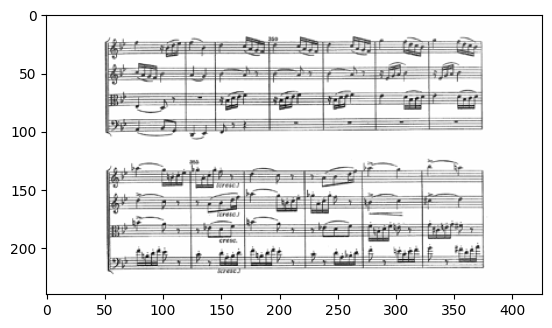

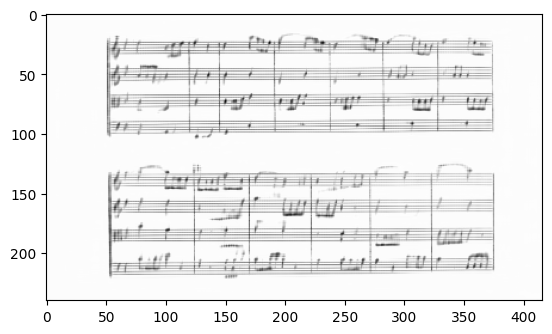

In [25]:
imshow(img.squeeze())
imshow(decoded.squeeze().cpu())